In [1]:
import warnings
warnings.filterwarnings('ignore')

# AICSImageIO
### Microscopy Image IO in Pure Python

<br>

Dask Summit 2021, Life Sciences Workshop

Jackson Maxfield Brown

## AICSImageIO at a High Level

AICSImageIO aims to provide a **consistent intuitive API for reading in or out-of-memory image pixel data and metadata** ...

To do so we mirror the Open Microscopy Environment (OME) metadata model as an object.

We don't try to do any fancy processing - instead we are solely concerned about _fast_ pure Python Microscopy file IO and _"good"_ metadata attachment and utilization.

In [2]:
from dask_image.imread import imread
da_img = imread("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
da_img

dask.array<_map_read_frame, shape=(666, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [3]:
from aicsimageio import AICSImage
aics_img = AICSImage("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
aics_img.dask_data

dask.array<transpose, shape=(1, 9, 74, 1024, 1024), dtype=uint16, chunksize=(1, 1, 74, 1024, 1024), chunktype=numpy.ndarray>

It also means that our image container is more than simply the array of voxels.

We provide easy access to dimension information, common pieces of metadata (or full access to metadata), support multi-scene files, writing / conversion shorthands, and more...

In [4]:
aics_img.dims

<Dimensions [T: 1, C: 9, Z: 74, Y: 1024, X: 1024]>

In [5]:
aics_img.channel_names

['DRAQ5',
 'EGFP',
 'Hoechst 33258',
 'TL Brightfield',
 'SEG_STRUCT',
 'SEG_Memb',
 'SEG_DNA',
 'CON_Memb',
 'CON_DNA']

In [6]:
aics_img.metadata

OME(
   experimenters=[<1 Experimenters>],
   images=[<1 Images>],
   instruments=[<1 Instruments>],
   uuid='urn:uuid:82cf0bcd-7e49-4cb1-b042-bd0aaa0b0590',
)

## Why Build AICSImageIO?

_Outside of simply wanting nice access to metadata..._

## Large Task Graphs and Issues with Image Processing

* We have the tools to take larger and larger images. 🙂
* We have the tools to create larger and larger datasets. 😀
* Dask delayed allows for just-in-time image reading. 😃
* Dask (and Prefect!) makes parallel processing easy. 😁
* The Dask scheduler falls over when processing millions of tasks. 😬
* Just-in-time image reading places a lot of tasks on the computation graph. 😅

* and.... the Dask Scheduler fell over. 😢

### Chunking (reducing the number of tasks caused by reading)

In [7]:
from dask_image.imread import imread
da_img = imread("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
da_img

dask.array<_map_read_frame, shape=(666, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

### Chunking (reducing the number of tasks caused by reading)

In [8]:
from aicsimageio import AICSImage
aics_img = AICSImage("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
aics_img.dask_data

dask.array<transpose, shape=(1, 9, 74, 1024, 1024), dtype=uint16, chunksize=(1, 1, 74, 1024, 1024), chunktype=numpy.ndarray>

In [9]:
import dask.array as da
import dask

def norm_and_proj_channel(data):
    # Get percentile norm by values
    min_px_val, max_px_val = da.percentile(
        data.flatten(),
        [50.0, 99.8],
    ).compute()

    # Norm
    normed = (data - min_px_val) / (max_px_val - min_px_val)

    # Clip any values outside of 0 and 1
    clipped = da.clip(normed, 0, 1)

    # Scale them between 0 and 255
    scaled = clipped * 255

    # Create max project
    return scaled.max(axis=0)

In [10]:
from matplotlib.pyplot import imshow, set_cmap
set_cmap("inferno")

<Figure size 432x288 with 0 Axes>

## Processing

Normalize all _raw content_ channels and generate a max projection (through Z dimension) for each.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.227033 to fit


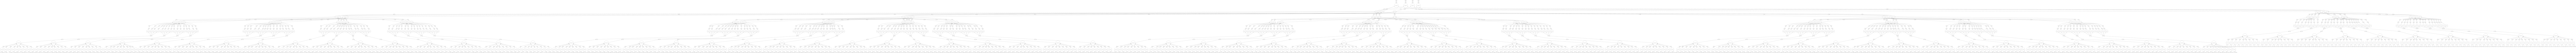

In [11]:
da_img = imread("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")
da_img = da_img.reshape(74, 9, 1024, 1024)

projs = []
for i in range(4):
    da_channel = da_img[:, i]
    projs.append(norm_and_proj_channel(da_channel))
    
da_projs = da.stack(projs)
dask.optimize(da_projs)[0].visualize()

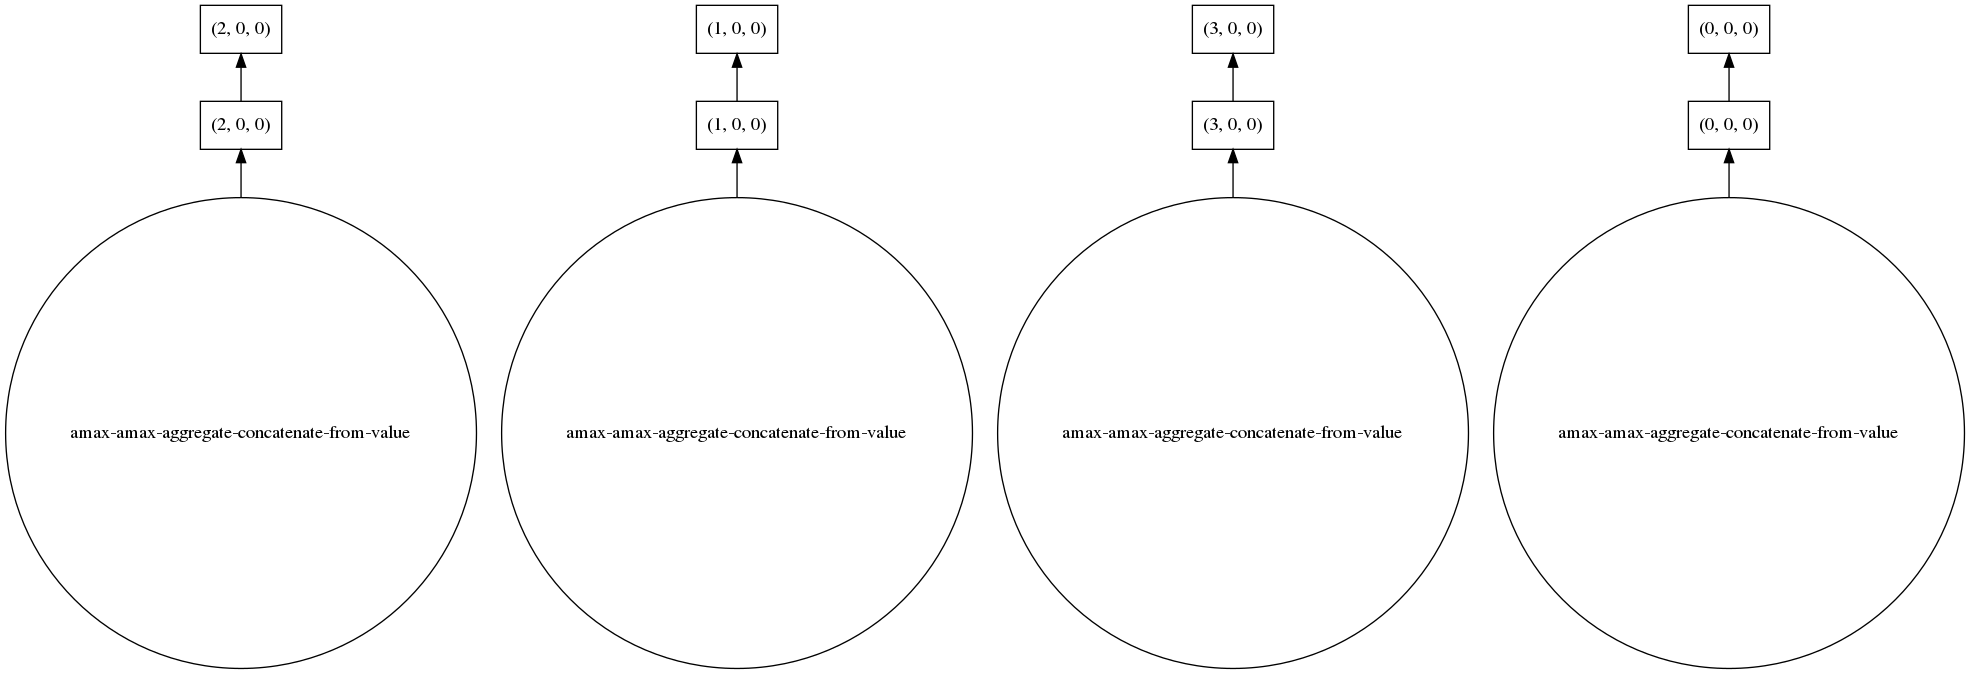

In [12]:
aics_img = AICSImage("../../aicsimageio/tests/resources/3d-cell-viewer.ome.tiff")

projs = []
for i, channel_name in enumerate(aics_img.channel_names):
    if channel_name in ["DRAQ5", "EGFP", "Hoechst 33258", "TL Brightfield"]:
        # get 3d array in ZYX order with just the selected channels data
        aics_channel = aics_img.get_image_dask_data("ZYX", C=i)
        projs.append(norm_and_proj_channel(aics_channel))

aics_projs = da.stack(projs)
dask.optimize(aics_projs)[0].visualize()

In [13]:
%%time
da_projs.compute().shape

CPU times: user 55.6 s, sys: 16.9 s, total: 1min 12s
Wall time: 50.4 s


(4, 1024, 1024)

In [14]:
%%time
aics_projs.compute().shape

CPU times: user 5.52 s, sys: 3.77 s, total: 9.3 s
Wall time: 2.77 s


(4, 1024, 1024)

In [15]:
from distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

In [16]:
%%time
da_projs.compute().shape

CPU times: user 6.82 s, sys: 280 ms, total: 7.1 s
Wall time: 17.2 s


(4, 1024, 1024)

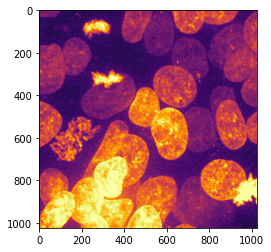

In [17]:
imshow(aics_projs[2])

## How??

Both `dask-image` and `aicsimageio` create delayed Dask arrays for just-in-time image reading - however, it's the size and configuration of the delayed chunks that matters most.

By utilizing metadata, we can cover the "95% user case" by enabling chunking by whole dimension sets (the default of "ZYX" chunks). This greatly reduces disk and network roundtrips.

And as a side effect of having larger chunks, the number of tasks on the graph is also greatly reduced!

## Chunking by Dimension

Our previous example was processing the Z-dimension of each channel, but what if you are working on timeseries data?

Set which dimensions to chunk by using `chunk_dims`:

In [18]:
AICSImage(
    "../../aicsimageio/tests/resources/image_stack_tpzc_50tp_2p_5z_3c_512k_1_MMStack_2-Pos000_000.ome.tif",
    chunk_dims="TYX",
).dask_data

[WARNING: ome_tiff_reader: 137 2021-05-13 23:05:17,497] Multi-image (or scene) OME-TIFFs created by MicroManager have limited support for scene API. It is recommended to use independent AICSImage or Reader objects for each file instead of the `set_scene` API. Track progress on support here: https://github.com/AllenCellModeling/aicsimageio/issues/196


dask.array<transpose, shape=(50, 3, 5, 256, 256), dtype=uint16, chunksize=(50, 1, 1, 256, 256), chunktype=numpy.ndarray>

## Large Task Graphs and Issues with Image Processing


* The dask scheduler _doesn't_ fall over...
<br><br>
* AICSImageIO reduces the number of tasks required for just-in-time image reading. 😌
* All the data processed! 😁

## Takeaways

Use metadata as a computation tool.
* _Images are more than just many 2D planes. They are n-D._
* _Use metadata to setup your array for faster processing._

Use metadata as a code legibility tool.
* _Use dimension names instead of slices and indices._

---

We can move from processing 1,000s of images at a time, to 10,000s of images at a time.

## Install

4.0 is just around the corner (and used in this presentation!)

`pip install aicsimageio --pre`

## Links

#### AICSImageIO
Repo: [github.com/AllenCellModeling/aicsimageio](https://github.com/AllenCellModeling/aicsimageio)<br>
Docs: [AllenCellModeling.github.io/aicsimageio](https://AllenCellModeling.github.io/aicsimageio)

#### Me
GitHub: [github.com/JacksonMaxfield](https://github.com/JacksonMaxfield)<br>
Twitter: [twitter.com/jmaxfieldbrown](https://twitter.com/jmaxfieldbrown)